| **Parameter**                         | **Description**                                                                                                                                                  | **Value/Example**                                               |
|---------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------|
| `p_steps`                             | The number of future time steps to predict.                                                                                                                        | `4 * 60 // samp` (depends on `samp`)                           |
| `backend`                             | The backend framework used for TimesFM model.                                                                                                                     | `"pt"` (PyTorch)                                               |
| `context_len`                         | The length of the historical context used for forecasting.                                                                                                       | `32`                                                          |
| `horizon_len`                         | The number of time steps to forecast (target horizon length).                                                                                                    | `p_steps`                                                      |
| `input_patch_len`                     | Length of the input patch for the model.                                                                                                                           | `32`                                                          |
| `output_patch_len`                    | Length of the output patch for the model.                                                                                                                          | `128`                                                         |
| `num_layers`                          | The number of layers in the model.                                                                                                                                  | `20`                                                          |
| `model_dims`                          | The dimensionality of the model's hidden layers.                                                                                                                  | `1280`                                                        |
| `use_positional_embedding`            | Whether positional embeddings are used in the model.                                                                                                              | `False`                                                       |
| `checkpoint`                          | Model checkpoint information for loading pretrained weights.                                                                                                     | `"google/timesfm-1.0-200m-pytorch"`                           |
| `samp`                                | Sampling interval in minutes for the dataset (used in file naming and sampling the data).                                                                         | `[5, 15, 30, 45, 60]` (varies)                                |
| `num_nodes`                           | Number of nodes (related to the dataset configuration).                                                                                                           | `[8, 16, 25]` (varies)                                        |
| `train`                               | DataFrame containing the training data subset.                                                                                                                     | `df.loc["2018-11-01":"2018-11-06"]`                           |
| `test`                                | DataFrame containing the test data subset.                                                                                                                         | `df.loc["2018-11-08":"2018-11-10"]`                           |
| `y_true`                              | Actual (ground truth) values from the test dataset.                                                                                                               | `test[col].values[:p_steps]`                                   |
| `y_pred`                              | Predicted values from the TimesFM model.                                                                                                                           | `pred[0][:p_steps]`                                            |
| `mae`                                 | Mean Absolute Error (metric for prediction accuracy).                                                                                                            | Calculated using `mean_absolute_error(y_true, y_pred)`         |
| `mape`                                | Mean Absolute Percentage Error (metric for prediction accuracy).                                                                                                 | Calculated using `mean_absolute_percentage_error(y_true, y_pred)` |
| `rmse`                                | Root Mean Squared Error (metric for prediction accuracy).                                                                                                        | Calculated using `np.sqrt(mean_squared_error(y_true, y_pred))` |
| `df_metrics`                          | DataFrame containing the results (metrics) for all node-sampling combinations.                                                                                   | Contains columns: `nodes`, `sampling`, `MAE`, `MAPE`, `RMSE`   |


In [1]:
!pip install timesfm
import pandas as pd
import numpy as np
import timesfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0].


In [7]:
!unzip /content/Dataset_perSampling_pernodeConfig-20250529T024432Z-1-001.zip

Archive:  /content/Dataset_perSampling_pernodeConfig-20250529T024432Z-1-001.zip
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_60min_8.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_30min_16.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_15min_25.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_30min_25.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_15min_16.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_45min_25.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_30min_8.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_45min_16.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_45min_8.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_60min_16.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperature_data_5min_16.csv  
  inflating: Dataset_perSampling_pernodeConfig/temperat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timesfm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Setup TimesFM pretrained model
def init_timesfm(p_steps):
    return timesfm.TimesFm(
        timesfm.TimesFmHparams(
            backend="pt",
            context_len=32,
            horizon_len=p_steps,
            input_patch_len=32,
            output_patch_len=128,
            num_layers=20,
            model_dims=1280,
            use_positional_embedding=False
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
        )
    )

results = []

for num_nodes in [8, 16, 25]:
    for samp in [5, 15, 30, 45, 60]:
        df = pd.read_csv(f"Dataset_perSampling_pernodeConfig/temperature_data_{samp}min_{num_nodes}.csv")
        df['ds'] = pd.to_datetime(df['ds'])
        df = df.set_index('ds').sort_index()
        train = df.loc["2018-11-01":"2018-11-06"]
        test = df.loc["2018-11-08":"2018-11-10"]

        p_steps = 4 * 60 // samp
        tfm = init_timesfm(p_steps)

        y_true = []
        y_pred = []
        for col in train.columns:
            hist = train[col].values.astype(float)
            actual = test[col].values[:p_steps]
            pred, _ = tfm.forecast([hist], freq=[0])
            y_pred.append(pred[0][:p_steps])
            y_true.append(actual)

        y_true = np.array(y_true).T
        y_pred = np.array(y_pred).T

        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        results.append((num_nodes, samp, mae, mape, rmse))
        print(f"nodes={num_nodes}, samp={samp} → MAE={mae:.3f}, MAPE={mape:.3f}, RMSE={rmse:.3f}")

df_metrics = pd.DataFrame(results, columns=['nodes', 'sampling', 'MAE', 'MAPE', 'RMSE'])
print("\n✅ Summary Metrics:")
print(df_metrics)


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

torch_model.ckpt:   0%|          | 0.00/814M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

nodes=8, samp=5 → MAE=6.389, MAPE=0.994, RMSE=8.663


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=8, samp=15 → MAE=9.348, MAPE=1.192, RMSE=11.276


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=8, samp=30 → MAE=22.931, MAPE=2.966, RMSE=24.410


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=8, samp=45 → MAE=8.224, MAPE=0.975, RMSE=10.207


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=8, samp=60 → MAE=22.382, MAPE=2.973, RMSE=25.823


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=16, samp=5 → MAE=6.859, MAPE=1.008, RMSE=9.271


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=16, samp=15 → MAE=11.034, MAPE=1.483, RMSE=13.272


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=16, samp=30 → MAE=22.445, MAPE=2.845, RMSE=23.772


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=16, samp=45 → MAE=7.788, MAPE=0.921, RMSE=9.473


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=16, samp=60 → MAE=21.468, MAPE=2.822, RMSE=25.045


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=25, samp=5 → MAE=6.957, MAPE=1.025, RMSE=9.441


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=25, samp=15 → MAE=9.816, MAPE=1.272, RMSE=12.118


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=25, samp=30 → MAE=21.038, MAPE=2.652, RMSE=22.961


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=25, samp=45 → MAE=7.301, MAPE=0.860, RMSE=8.998


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

nodes=25, samp=60 → MAE=21.587, MAPE=2.787, RMSE=25.146

✅ Summary Metrics:
    nodes  sampling        MAE      MAPE       RMSE
0       8         5   6.388525  0.993998   8.662853
1       8        15   9.348207  1.192350  11.276046
2       8        30  22.930772  2.965941  24.410239
3       8        45   8.224099  0.974516  10.206859
4       8        60  22.381693  2.973202  25.823307
5      16         5   6.859072  1.007902   9.270666
6      16        15  11.033747  1.483084  13.272470
7      16        30  22.444667  2.845347  23.772318
8      16        45   7.788394  0.921093   9.473453
9      16        60  21.468475  2.821558  25.044653
10     25         5   6.957472  1.025085   9.441449
11     25        15   9.815512  1.272430  12.117977
12     25        30  21.038081  2.651612  22.961473
13     25        45   7.301239  0.860369   8.997919
14     25        60  21.587274  2.787125  25.146250


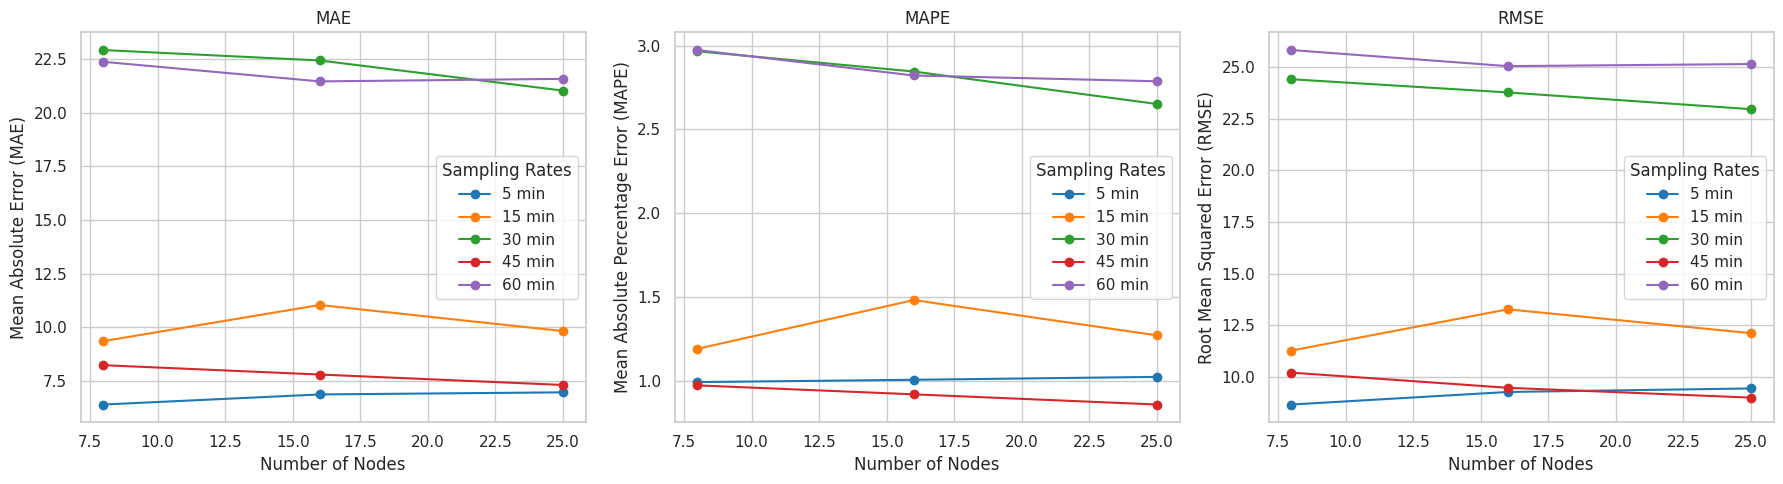

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: style
sns.set(style="whitegrid")

# Ensure sampling is categorical for consistent plotting
df_metrics['sampling'] = df_metrics['sampling'].astype(str)

# Get the unique sampling rates
sampling_rates = df_metrics['sampling'].unique()
colors = sns.color_palette("tab10", len(sampling_rates))

# Define the metrics to plot
metrics = ['MAE', 'MAPE', 'RMSE']
y_labels = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'MAPE': 'Mean Absolute Percentage Error (MAPE)'
}

# Create one plot per metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

for ax, metric in zip(axes, metrics):
    for i, sampling_rate in enumerate(sampling_rates):
        df_subset = df_metrics[df_metrics['sampling'] == sampling_rate]
        df_subset = df_subset.sort_values(by='nodes')
        ax.plot(df_subset['nodes'], df_subset[metric], label=f'{sampling_rate} min', color=colors[i], marker='o')

    ax.set_title(metric)
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel(y_labels[metric])
    ax.legend(title='Sampling Rates')

plt.tight_layout()
plt.show()


In [ ]:
df_metrics.columns

Index(['nodes', 'sampling', 'MAE', 'MAPE', 'RMSE'], dtype='object')

In [ ]:
df = df.rename(columns={
    'NUM_NODES': 'nodes',
    'SAMPLING_MIN': 'sampling'
})


In [ ]:
print(df.columns)
print(df_metrics.columns)

Index(['MAC000025', 'MAC000018', 'MAC000002', 'MAC000010', 'MAC000024',
       'MAC000005', 'MAC000031', 'MAC000023', 'MAC000007', 'MAC000030',
       'MAC000026', 'MAC000009', 'MAC000008', 'MAC000004', 'MAC000027',
       'MAC000014', 'MAC000011', 'MAC000028', 'MAC000013', 'MAC000032',
       'MAC000003', 'MAC000012', 'MAC000006', 'MAC000021', 'MAC000015'],
      dtype='object')
Index(['nodes', 'sampling', 'MAE', 'MAPE', 'RMSE'], dtype='object')


In [ ]:
print(df.shape)
print(df_metrics.shape)

(218, 25)
(15, 5)


In [ ]:
import pandas as pd
df = pd.read_csv('metrics_log.csv')
df.columns

FileNotFoundError: [Errno 2] No such file or directory: 'metrics_log.csv'

In [ ]:
import pandas as pd

# Ensure both dataframes have consistent dtypes
for df_ in [df_metrics, df]:
    df_['sampling'] = df_['sampling'].astype(int)
    df_['nodes'] = df_['nodes'].astype(int)

# Merge on sampling and nodes
merged = pd.merge(df_metrics, df, on=['sampling', 'nodes'], suffixes=('_tsfm', '_moirai'))
merged = merged.sort_values(by=['sampling', 'nodes'])

# Format LaTeX row
def format_row(sampling, nodes, tsfm, moirai):
    f = lambda v: f"{v['MAE']:.3f} / {v['MAPE']:.1f}\\% / {v['RMSE']:.3f}"
    return f"  {sampling:<2}  &  {nodes:<2}  & {f(tsfm)} & {f(moirai)} \\\\"

latex_rows = []
for _, row in merged.iterrows():
    tsfm_vals = {'MAE': row['MAE_tsfm'], 'MAPE': row['MAPE_tsfm'], 'RMSE': row['RMSE_tsfm']}
    moirai_vals = {'MAE': row['MAE_moirai'], 'MAPE': row['MAPE_moirai'], 'RMSE': row['RMSE_moirai']}
    latex_rows.append(format_row(row['sampling'], row['nodes'], tsfm_vals, moirai_vals))

# Wrap in LaTeX table format
latex_code = r"""
\begin{table}[H]
  \centering
  \caption{Temporal Forecasting: TimesFM vs Moirai error metrics across sampling rates and node subsets}
  \label{tab:timesfm_moirai_errors}
  \scriptsize
  \setlength{\tabcolsep}{4pt}
  \begin{adjustbox}{max width=\textwidth}
  \tiny
    \begin{tabular}{rr|ll}
      \toprule
      Sampling & Nodes in Subset &
      \textbf{TimesFM} (MAE / MAPE / RMSE) &
      \textbf{Moirai} (MAE / MAPE / RMSE) \\
      \midrule
""" + "\n".join(latex_rows) + r"""
      \bottomrule
    \end{tabular}
  \end{adjustbox}
\end{table}
"""

print(latex_code)
